In [ ]:
from collections import Counter, defaultdict
import os
from pathlib import Path
import pickle
import random
import string

import iisignature
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import scipy
from sklearn import covariance, ensemble, metrics, random_projection, model_selection, neighbors, neural_network
import sklearn.cluster

import torch
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel
import umap
import zarr

plt.rcParams['figure.dpi'] = 200

# Path Signatures for Natural Language Processing

Written text is an example of a high-dimensional data stream. Highly successful and popular machine learning approaches involving such forms of natural language are neural network architectures called transformers. In this notebook, we showcase how to harness the capabilities of path signatures and transformers. Specifically, we consider the challenge of determining whether a text was written by an author that we have not yet encountered in a corpus of unlabelled texts.

At a conceptual level, the approach demonstated in this notebook uses the following pipeline for processing a stream of text:
* Read in the stream of text corresponding to a literary work
* Tokenize the text into a stream of integers and split into chunks each consisting of 512 tokens (tokens may correspond to words, but also punctuation marks, word stems (e.g. *analys*-) and affixes (e.g. *re*-, -*ing*, *-ed*)). **Length: 512 observations; dimensionality: approx. 30,000**
* Use a pre-trained language model (BERT) to obtain embeddings of token streams. **Length: 512 observations; dimensionality: 1024**
* Use UMAP (VAEs) to further reduce dimensionality of stream embeddings. **Length: approx. 256 observations; dimensionality: 4**
* Compute path signature. **Dimensionality: 340 (level 4 signature)**

We operate on chunks of text, with each chunk consising of 512 tokens and thus corresponding approximately to one paragraph of written text. At training time, we train an anomaly detection model on path signatures as our feature vectors, thus each path signature corresponds to one chunk of text.

Notably, we demonstrate a scoring technique which produces a single anomaly score for the set of multiple chunks that we obtain for a single literatary work of interest. This technique relies on comparing the two empirical score distributions that we obtain using the literatary work of interest and a subset of training data. By using multiple chunks in this this way, we increase the statistical power of our approach, compared to simply scoring a single chunk of text.

## Read in Dataset

This notebook uses the Standardised Project Gutenberg Corpus (Gerlach and Font-Clos, 2018). For reproducability, it is recommended that you download the 'frozen' dataset available at https://zenodo.org/record/2422561/files/SPGC-tokens-2018-07-18.zip?download=1. Alternatively, it is possible to obtain a (non-reproducible) 'live snapshot' of the dataset by running the data extraction code available at https://github.com/pgcorpus/gutenberg.

Once you have successfully downloaded the dataset, make sure that the value of the following variable **DATASET_PATH** is set to the correct path containing the dataset (it needs to be the path leading up to the directories *metadata* and *data*):

In [3]:
# Set this variable to the path containing the dataset
DATASET_PATH = '/scratch/fosterp/gutenberg/gutenberg/'

Read in table of metadata from CSV file and display final rows in the table:

In [3]:
df = pd.read_csv(Path(DATASET_PATH, 'metadata', 'metadata.csv'))
df.set_index('id', inplace=True, drop=False)
df.tail()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,,
PG67405,PG67405,Woman in the golden ages,"Mason, Amelia Gere",NaN,NaN,['en'],0,set(),NaN
PG67406,PG67406,The Husband’s Story,"Phillips, David Graham",1867.0,1911.0,['en'],0,set(),NaN
PG67407,PG67407,Haarmann. Die Geschichte eines Werwolfs: Außen...,"Lessing, Theodor",NaN,NaN,['de'],0,set(),NaN
PG67408,PG67408,La verbena de la Paloma,"Vega, Ricardo de la",NaN,NaN,['es'],0,set(),NaN
PG90907,PG90907,NaN,NaN,NaN,NaN,['en'],1,set(),Text


Each row in the table corresponds to one literary work (e.g. a novel). We consider only works for which the *author* field is defined:

In [4]:
df = df[df['author'].notnull()]

In [5]:
len(df)

64795

Load the (pre-trained) transformer and determine if CUDA is available, so that we may benefit from using a GPU:

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaModel.from_pretrained('roberta-large').to(DEVICE)

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
N_CHUNKS = 10
CHUNK_SIZE = 512
BERT_DIMENSIONALITY = 1024

For each work in the dataset, compute stream embeddings. We obtain stream embeddings as follows:
* Read in the stream of text
* Tokenize the text into a stream of integers
* Extract 10 non-overlapping chunks located at the middle of the token stream, with each chunk consisting of 512 tokens
* For each of the chunks, compute a stream embedding. The stream embedding is 1024-dimensional and consists of 512 observations.

## Compute Stream Embeddings

In [9]:
def compute_embeddings(input_file_path,
                       chunk_size=CHUNK_SIZE, max_chunks=N_CHUNKS):
    with open(input_file_path, 'r') as f:
        # Replace newlines with spaces
        text = [line.replace('\n', ' ') for line in f.readlines()]
        # Concatenate all elements into one string
        text = ''.join(text)
        # Munge repeated spaces into one
        text = ' '.join(text.split())
        
        encoded_input = tokenizer(text, return_tensors='pt').to(DEVICE)
        length = len(encoded_input['input_ids'][0])
        
        if max_chunks is not None:
            strt_idx = length // 2 - (chunk_size // 2) * max_chunks
            end_idx = length // 2 + (chunk_size // 2) * max_chunks
            encoded_input = {k: (v[0][strt_idx:end_idx]).reshape(1, len(v[0][strt_idx:end_idx]))
                             for k, v in encoded_input.items()}
        
        embeddings = []
        all_encoded_input = []
        while length > 0:
            if length > chunk_size:
                next_inputs = {k: (v[0][chunk_size:]).reshape(1, len(v[0][chunk_size:]))
                               for k, v in encoded_input.items()}
                encoded_input = {k: (v[0][:chunk_size]).reshape(1, len(v[0][:chunk_size]))
                                 for k, v in encoded_input.items()}
            else:
                next_inputs = None

            all_encoded_input.append(encoded_input['input_ids'].detach().cpu().numpy()[0])
            embeddings.append(model(**encoded_input).last_hidden_state.detach().cpu().numpy()[0])
            
            if next_inputs:
                encoded_input = next_inputs
            else:
                break
                                
            length = len(encoded_input['input_ids'][0])
            
        for data in embeddings, all_encoded_input:
            assert(all([len(d) == chunk_size for d in data]))
            assert(len(data) == max_chunks)

        embeddings = np.array(embeddings)
        all_encoded_input = np.array(all_encoded_input)
            
        return embeddings, all_encoded_input

In [1]:
# Uncomment the following line to delete all stream embeddings.
#!rm -r {DATASET_PATH}/data/embeddings

Obtain stream embeddings for all works in the dataset:

In [11]:
def compute_all_embeddings(input_dir=Path(DATASET_PATH, 'data/text'),
                           output_dir=Path(DATASET_PATH, 'data/embeddings')):
    if os.path.exists(output_dir):
        return
    
    input_files = [f for f in os.listdir(input_dir) if '.txt' in f]
    random.shuffle(input_files)
    
    em, enc = compute_embeddings(Path(input_dir, input_files[0]))
    
    embeddings = zarr.open(Path(output_dir, 'embeddings'), mode='w',
                           shape=(len(input_files),) + em.shape,
                           chunks=(1, None, None, None), dtype=em.dtype)
    encoded_input = zarr.open(Path(output_dir, 'encoded_input'), mode='w',
                              shape=(len(input_files),) + enc.shape,
                              chunks=(1, None, None), dtype=enc.dtype)
    
    successful_embeddings = {}
    for n, input_file in enumerate(tqdm(input_files, smoothing=0.001)):
        try:
            embeddings[n], encoded_input[n] = compute_embeddings(Path(input_dir, input_file))
            
            successful_embeddings[input_file.replace('_text.txt', '')] = n
        except ValueError as e:
            print('Error while computing embeddings for {} {}'.format(input_file, e))
        except AssertionError:
            pass
            
    successful_embeddings = pd.Series(successful_embeddings)
    successful_embeddings.to_csv(Path(output_dir, 'successful_embeddings.csv'))

In [12]:
compute_all_embeddings()

## Partition Dataset

Consider only English-language works:

In [13]:
df = df[df['language'] == "['en']"]

Consider only works for which we have sucessfully computed stream embeddings:

In [14]:
successful_embeddings = pd.read_csv(Path(DATASET_PATH, 'data/embeddings/successful_embeddings.csv'),
                                    index_col=0, header=0, names=['embedding_index'])

df = df.merge(successful_embeddings, left_index=True, right_index=True)

Count the number of works for each author and display the most prolific authors:

In [15]:
df.groupby('author').apply(len).sort_values()

author
A British officer                          1
Michelson, Albert A. (Albert Abraham)      1
Michell, Thomas                            1
Michelet, Jules                            1
Michaelis, Richard                         1
                                        ... 
Haggard, H. Rider (Henry Rider)           59
Balzac, Honoré de                         79
Oliphant, Mrs. (Margaret)                 97
Anonymous                                151
Various                                  832
Length: 8239, dtype: int64

Next, we partition the dataset. We consider an anomaly detection task where we are interested in determining if a given text fragment was written by any of the authors associated with text fragments in a training corpus, or if it was written by a hitherto unseen author.

To this end, we designate works written by the 19th century Scottish novelist Margaret Oliphant as 'anomalous'. We use all remaining works for the 'normal' training corpus and 'normal' testing subset, where we require that there are at least 9 works by each author in the training corpus, for all authors in the 'normal' testing subset. (That is, there may be authors in the training corpus which are represented with fewer than 9 works. However, such authors do not appear in the 'normal' testing subset.)

In [16]:
np.random.seed(4)
df_impostor = df[df['author'] == 'Oliphant, Mrs. (Margaret)']

df_normal = df[df['author'] != 'Oliphant, Mrs. (Margaret)']
df_normal_authors = df_normal.groupby('author').apply(lambda g: len(g) >= 10)
df_normal_authors = df_normal_authors[df_normal_authors]
df_normal_with_multiple_per_author = df_normal[df_normal['author'].apply(lambda author: author in set(df_normal_authors.index))]
df_normal_eval = df_normal_with_multiple_per_author.groupby('author').sample(n=1, random_state=8)
df_normal_train = df_normal[df_normal['id'].apply(lambda book_id: book_id not in set(df_normal_eval['id']))]

## Reduce Dimensionality of Stream Embeddings

Implement a class for representing our data. Notably, we implement functionality for taking stream embeddings and deleting all those observations contained in the stream embeddings which do not correspond to frequently occuring tokens. In addition, we implement functionality for reducing the dimensionality of stream embeddings:

In [59]:
class Dataset:
    EMBEDDINGS = zarr.open(Path(DATASET_PATH, 'data/embeddings/embeddings'), mode='r')
    ENCODED_INPUT = zarr.open(Path(DATASET_PATH, 'data/embeddings/encoded_input'), mode='r')
    
    def __init__(self, df_normal_train, df_normal_eval, df_impostor, description, n_most_frequent_tokens=None):
        self.df_normal_train = df_normal_train
        self.df_normal_eval = df_normal_eval
        self.df_impostor = df_impostor
        self.description = description
        
        self.token_ids_normal_train = Dataset._load_tokens_from_storage(df_normal_train)
        self.token_ids_normal_eval = Dataset._load_tokens_from_storage(df_normal_eval)
        self.token_ids_impostor = Dataset._load_tokens_from_storage(df_impostor)
        
        if n_most_frequent_tokens:
            self.token_frequencies_normal_train = \
                pd.Series(Counter(np.ravel(self.token_ids_normal_train)))
            self.token_frequencies_normal_train.sort_values(ascending=False, inplace=True)
            self.token_frequencies_normal_train = \
                (self.token_frequencies_normal_train / self.token_frequencies_normal_train.sum()).cumsum()

            self.top_n_tokens_normal_train = list(self.token_frequencies_normal_train[:n_most_frequent_tokens].index)

            self.token_ids_normal_train = \
            Dataset._mask_tokens(self.token_ids_normal_train, self.top_n_tokens_normal_train)
            self.token_ids_normal_eval = \
                Dataset._mask_tokens(self.token_ids_normal_eval, self.top_n_tokens_normal_train)
            self.token_ids_impostor = \
                Dataset._mask_tokens(self.token_ids_impostor, self.top_n_tokens_normal_train)

    def _load_tokens_from_storage(df):
        return Dataset.ENCODED_INPUT.get_orthogonal_selection(df['embedding_index'])
    
    def _mask_tokens(token_ids, valid_token_set):
        mask = ~np.isin(token_ids, np.array(valid_token_set))
        token_ids = ma.masked_array(token_ids, mask)
            
        return token_ids
    
    def _project_embeddings(df, all_token_ids, projection_function):
        projected_embeddings = []
        for embedding_index, token_ids in  tqdm(zip(df['embedding_index'], all_token_ids),
                                                total=len(all_token_ids)):
            embeddings = Dataset.EMBEDDINGS.get_orthogonal_selection(embedding_index)
            
            embeddings = [em[~tok.mask] for em, tok in zip(embeddings, token_ids)]
            
            projected_embeddings.append([projection_function(em) for em in embeddings])
            
        return projected_embeddings
    
    def compute_mean(self):
        local_means = []
        num_samples = []
        for embedding_index, token_ids in tqdm(zip(self.df_normal_train['embedding_index'],
                                                   self.token_ids_normal_train),
                                               total=len(self.token_ids_normal_train)):
            embeddings = list(Dataset.EMBEDDINGS.get_orthogonal_selection(embedding_index))
            embeddings = [em[~tok.mask] for em, tok in zip(embeddings, token_ids)]
            
            local_means.append(np.array([np.mean(em, axis=0) for em in embeddings]))
            num_samples.append(np.array([sum(~tok.mask) for tok in token_ids]))
            
        local_means = np.array(local_means)
        local_means = local_means.reshape(-1, local_means.shape[-1])
        num_samples = np.ravel(num_samples).astype(float)
        num_samples /= np.sum(num_samples)
            
        return np.nansum(local_means * np.atleast_2d(num_samples).T, axis=0)
    
    def project_embeddings(self, projection_function=None):        
        self.embeddings_projected_normal_train = Dataset._project_embeddings(self.df_normal_train,
                                                                             self.token_ids_normal_train,
                                                                             projection_function)
        self.embeddings_projected_normal_eval = Dataset._project_embeddings(self.df_normal_eval,
                                                                            self.token_ids_normal_eval,
                                                                            projection_function)
        self.embeddings_projected_impostor = Dataset._project_embeddings(self.df_impostor,
                                                                         self.token_ids_impostor,
                                                                         projection_function)

For each method that we seek to evaluate, instantiate a dataset object.

We will contrast two methods for reducing the dimensionality of stream embeddings:
* UMAP-based dimensionality reduction
* Random projections

Prior to projecting stream embeddings, we delete all those observations contained in the stream embeddings which do not correspond to the $K$ most frequent tokens in the trainning corpus, where we consider $K \in {100, 250}$. Thus, we have instantiate four dataset objects:

In [60]:
dataset0 = Dataset(df_normal_train, df_normal_eval, df_impostor,
                   'Apply UMAP to stream embeddings only considering 250 most frequent tokens, '
                   'then map all token embeddings only for those same tokens', n_most_frequent_tokens=250)

In [61]:
dataset1 = Dataset(df_normal_train, df_normal_eval, df_impostor,
                   'Apply UMAP to stream embeddings only considering 100 most frequent tokens, '
                   'then map all token embeddings only for those same tokens', n_most_frequent_tokens=100)

In [62]:
dataset2 = Dataset(df_normal_train, df_normal_eval, df_impostor,
                   'Randomly project stream embeddings only considering 100 most frequent tokens, '
                   'then map all token embeddings only for those same tokens', n_most_frequent_tokens=100)

In [63]:
dataset3 = Dataset(df_normal_train, df_normal_eval, df_impostor,
                   'Randomly project stream embeddings only considering 250 most frequent tokens, '
                   'then map all token embeddings only for those same tokens', n_most_frequent_tokens=250)

In [28]:
dataset0.projection_mean_offset = dataset0.compute_mean()
dataset1.projection_mean_offset = dataset1.compute_mean()

dataset2.projection_mean_offset = dataset1.projection_mean_offset
dataset3.projection_mean_offset = dataset0.projection_mean_offset

  8%|██████▎                                                                     | 1429/17238 [00:50<09:11, 28.66it/s]/home/fosterp/miniconda3/envs/language_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fosterp/miniconda3/envs/language_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|███████████████████████████████████████████████████████████████████████████| 17238/17238 [06:57<00:00, 41.28it/s]


Based on the training corpus, the 250 most frequent tokens account for approx. 57.6% of all observations:

In [29]:
max(dataset0.token_frequencies_normal_train[:250].values)

0.576500001812855

Plot the cumulative distributions of tokens in the training corpus:

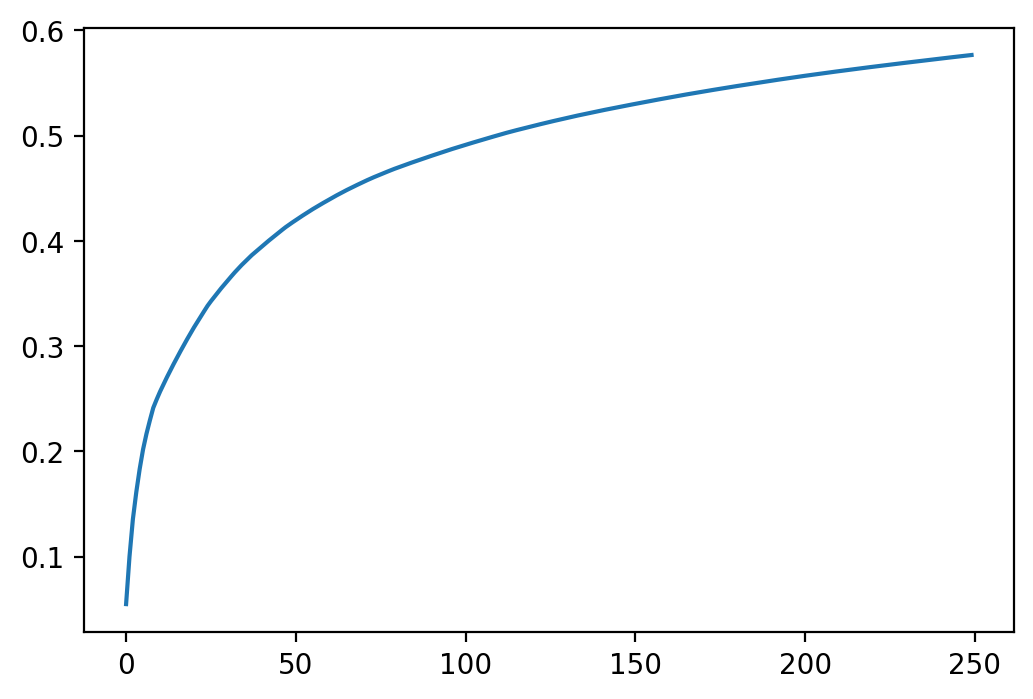

In [30]:
plt.plot(dataset0.token_frequencies_normal_train[:250].values)

Print out the corresponding token values:

In [32]:
print([tokenizer.decode(t) for t in dataset0.top_n_tokens_normal_train])

[',', ' the', '.', ' of', ' and', ' to', ' a', ' in', '�', ' that', ' was', ' �', ' I', ' is', '�', ' it', '�', ' he', '�', ' his', ' with', ' as', '-', ' for', ';', ' be', ' had', ' on', ' The', ' not', ' at', ' by', ' you', 's', ' which', ' her', ' from', ' have', ' are', ' this', ' _', ' but', ' or', ' were', ' they', ' all', '_', ' him', ' one', ' their', ' she', ' an', '?', '!', ' so', ' we', ' my', ' me', ':', ' them', '--', ' "', ' been', ' said', ' would', ' who', ' He', ' will', ' no', ' there', ' out', ' when', ' up', ' more', ' It', ' into', '—', ' if', ' has', 't', 'I', ' its', ' some', ' man', ' time', ' And', ' do', ' very', ' could', ' what', ' other', ' than', ' about', ' can', ' (', "'s", ' our', ' only', ' But', ' any', ' A', ' little', ' upon', ' your', ' two', ' then', 'ly', ' like', ' over', ' In', ' now', ' may', ' made', 'ed', ' these', ' us', ' great', ' should', ' before', ' down', ' did', ' must', ' first', ' such', ' see', ']', ' much', ' know', ' [', ' where

In [33]:
print([tokenizer.decode(t) for t in dataset1.top_n_tokens_normal_train])

[',', ' the', '.', ' of', ' and', ' to', ' a', ' in', '�', ' that', ' was', ' �', ' I', ' is', '�', ' it', '�', ' he', '�', ' his', ' with', ' as', '-', ' for', ';', ' be', ' had', ' on', ' The', ' not', ' at', ' by', ' you', 's', ' which', ' her', ' from', ' have', ' are', ' this', ' _', ' but', ' or', ' were', ' they', ' all', '_', ' him', ' one', ' their', ' she', ' an', '?', '!', ' so', ' we', ' my', ' me', ':', ' them', '--', ' "', ' been', ' said', ' would', ' who', ' He', ' will', ' no', ' there', ' out', ' when', ' up', ' more', ' It', ' into', '—', ' if', ' has', 't', 'I', ' its', ' some', ' man', ' time', ' And', ' do', ' very', ' could', ' what', ' other', ' than', ' about', ' can', ' (', "'s", ' our', ' only', ' But', ' any']


To reduce the dimensionality of stream embeddings, we initially apply UMAP to a subset of the 1024-dimensional feature vectors that comprise the stream embeddings in the training corpus (where we weight samples based on token frequencies).

Since it is relatively computationally expensive to apply UMAP to unseen feature vectors, we train a feedforward network as a function approximator; as the target function we use the aforementioned data before and after applying UMAP.

To help assess the fidelity of the described dimensionality reduction, we use K-nearest neighbour classification to predict the token classes of unseen data.

### Apply UMAP

In [161]:
def train(dataset):
    DOWNSAMPLE_FACTOR = 10
    token_ids = dataset.token_ids_normal_train
    embedding_index = dataset.df_normal_train['embedding_index']
    
    np.random.seed(4)
    
    freqs = Counter(np.ravel(token_ids.compressed()))
    inverse_freqs = {k:1/v for k,v in freqs.items()}
    
    compute_weights = np.vectorize(lambda token_id: inverse_freqs[token_id]
                                   if token_id in inverse_freqs.keys() else 0)
    weights = compute_weights(token_ids)
    
    # Split into train and validation sets
    # NB: This ensures that we separate at the level of text fragments! (It thus might avoid information leakage)
    embedding_index_train, embedding_index_validate, weights_train, weights_validate, token_ids_train, token_ids_validate = model_selection.train_test_split(embedding_index, weights, token_ids, train_size=1000, test_size=1000)
    
    # Use only the first chunk for training
    data_train = Dataset.EMBEDDINGS.get_orthogonal_selection((embedding_index_train, 0))
    data_train = data_train.reshape(-1, data_train.shape[-1])
    token_ids_train = np.ravel(token_ids_train[:, 0])
    weights_train = np.ravel(weights_train[:, 0])
    data_train = data_train[~weights_train.mask]
    token_ids_train = token_ids_train[~weights_train.mask]
    weights_train = weights_train[~weights_train.mask]
    # Sample without replacement (this avoids repeated data points), while ensuring approximately balanced sample
    I = np.random.choice(len(data_train), size=len(data_train)//DOWNSAMPLE_FACTOR, p=weights_train/sum(weights_train), replace=False)
    data_train = data_train[I]
    token_ids_train = token_ids_train[I]
    
    data_validate = Dataset.EMBEDDINGS.get_orthogonal_selection((embedding_index_validate, 0))
    data_validate = data_validate.reshape(-1, data_validate.shape[-1])
    token_ids_validate = np.ravel(token_ids_validate[:, 0])
    weights_validate = np.ravel(weights_validate[:, 0])
    data_validate = data_validate[~weights_validate.mask]
    token_ids_validate = token_ids_validate[~weights_validate.mask]
    weights_validate = weights_validate[~weights_validate.mask]
    # Sample with replacement (we don't require that data points are unique), while ensuring approximately balanced sample
    I = np.random.choice(len(data_validate), size=len(data_validate)//DOWNSAMPLE_FACTOR, p=weights_validate/sum(weights_validate))
    data_validate = data_validate[I]
    token_ids_validate = token_ids_validate[I]
    
    dataset.umap.fit(data_train)
    data_train_transformed = dataset.umap.transform(data_train)
    
    ann = neural_network.MLPRegressor(solver='adam', hidden_layer_sizes=(1024,1024,), verbose=True,
                                      early_stopping=True, max_iter=1000, random_state=23)
    ann.fit(data_train, data_train_transformed)
        
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(ann.predict(data_train), token_ids_train)
    score = knn.score(ann.predict(data_validate), token_ids_validate)

    return score, ann

Use UMAP to reduce the dimensionality of stream embeddings from 1024 to 4 dimensions:

In [164]:
dataset0.umap = umap.UMAP(n_components=4, min_dist=0.99, n_neighbors=20, transform_seed=23)
dataset0.score, dataset0.ann = train(dataset0)
print(dataset0.score)

Iteration 1, loss = 2.13197964
Validation score: 0.920894
Iteration 2, loss = 0.30197844
Validation score: 0.958200
Iteration 3, loss = 0.15601429
Validation score: 0.969168
Iteration 4, loss = 0.10506351
Validation score: 0.972991
Iteration 5, loss = 0.07639763
Validation score: 0.976793
Iteration 6, loss = 0.05687296
Validation score: 0.977087
Iteration 7, loss = 0.04577291
Validation score: 0.977717
Iteration 8, loss = 0.03765355
Validation score: 0.979536
Iteration 9, loss = 0.03156461
Validation score: 0.980851
Iteration 10, loss = 0.02790828
Validation score: 0.979930
Iteration 11, loss = 0.02456832
Validation score: 0.981355
Iteration 12, loss = 0.02295816
Validation score: 0.981768
Iteration 13, loss = 0.02254934
Validation score: 0.981900
Iteration 14, loss = 0.02013234
Validation score: 0.982241
Iteration 15, loss = 0.01886568
Validation score: 0.982705
Iteration 16, loss = 0.01783066
Validation score: 0.982606
Iteration 17, loss = 0.01743260
Validation score: 0.982451
Iterat

For exploratory purposes, we furthermore use UMAP to reduce the dimensionality of stream embeddings from 1024 to 2 dimensions:

In [132]:
dataset1.umap = umap.UMAP(n_components=2, min_dist=0.99, n_neighbors=20, transform_seed=23)
dataset1.score, dataset1.ann = train(dataset1)
print(dataset1.score)

Iteration 1, loss = 9.35455230
Validation score: 0.958311
Iteration 2, loss = 1.01945044
Validation score: 0.977159
Iteration 3, loss = 0.50942628
Validation score: 0.980939
Iteration 4, loss = 0.30381409
Validation score: 0.984584
Iteration 5, loss = 0.20063514
Validation score: 0.985270
Iteration 6, loss = 0.14873804
Validation score: 0.986989
Iteration 7, loss = 0.10602630
Validation score: 0.987653
Iteration 8, loss = 0.08814442
Validation score: 0.987977
Iteration 9, loss = 0.07486788
Validation score: 0.988431
Iteration 10, loss = 0.06295941
Validation score: 0.988882
Iteration 11, loss = 0.06166770
Validation score: 0.988966
Iteration 12, loss = 0.05397566
Validation score: 0.989025
Iteration 13, loss = 0.05985532
Validation score: 0.989331
Iteration 14, loss = 0.05265637
Validation score: 0.989532
Iteration 15, loss = 0.04703242
Validation score: 0.989738
Iteration 16, loss = 0.04942131
Validation score: 0.989920
Iteration 17, loss = 0.05823589
Validation score: 0.989584
Iterat

We observe that we are able to predict the token class of unseen feature vectors with a classification accuracy exceeding 90%. Given that we have 100 (alternatively 250) possible tokens, this result strongly suggests that dimensionality reduction preserves information about input tokens contained in the original stream embeddings.

Reduce the dimensionality of stream embeddings in the remaining training and testing subsets:

In [165]:
dataset0.project_embeddings(lambda em: dataset0.ann.predict(em) if len(em) > 0 else np.zeros((0, dataset0.umap.n_components)))
dataset1.project_embeddings(lambda em: dataset1.ann.predict(em) if len(em) > 0 else np.zeros((0, dataset1.umap.n_components)))

100%|█████████████████████████████████████████████████████████████████████████████████| 97/97 [00:04<00:00, 20.10it/s]


### Apply Random Projections Baseline

As a baseline, randomly project the stream embeddings down to 2 (alternatively 4) dimensions:

In [221]:
np.random.seed(4)
dataset2.projection_matrix = np.random.normal(size=(len(dataset2.projection_mean_offset), 2))
dataset2.project_embeddings(lambda em: (em-dataset2.projection_mean_offset) @ dataset2.projection_matrix)

In [222]:
np.random.seed(4)
dataset3.projection_matrix = np.random.normal(size=(len(dataset3.projection_mean_offset), 4))
dataset3.project_embeddings(lambda em: (em-dataset3.projection_mean_offset) @ dataset3.projection_matrix)

In [223]:
with open(Path(DATASET_PATH, 'data', 'embedding_datasets.pkl'), 'wb') as f:
    pickle.dump((dataset0, dataset1, dataset2, dataset3), f, protocol=pickle.HIGHEST_PROTOCOL)

### Explore Dimensionality-Reduced Stream Embeddings

In [134]:
def plot_encodings(dataset1, cluster_label_map=None, n_samples=3*10**5,
                   dbscan_max_num_subclusters=3, dbscan_eps=0.3, include_labels=True):
    
    encodings = np.vstack([np.vstack(encodings) for encodings in dataset1.embeddings_projected_normal_train])
    encodings = encodings[:, :2]
    
    cluster_assignments = np.ravel(dataset1.token_ids_normal_train)
    cluster_assignments = cluster_assignments[~cluster_assignments.mask]

    I = np.random.choice(len(cluster_assignments), size=n_samples)
    cluster_assignments = cluster_assignments[I]
    encodings = encodings[I]
    
    clusters = np.unique(cluster_assignments)
    
    cmap = matplotlib.cm.get_cmap(name='tab20b')
    colors = cmap(np.linspace(0, 1, len(clusters)))
    color_map = {k: colors[i] for i, k in enumerate(clusters)}

    for c in cluster_assignments:
        color_map[c]

    scatter = plt.scatter(*encodings.T.tolist(), c=[color_map[c] for c in cluster_assignments],
                          label=cluster_assignments, s=0.2, alpha=0.5)
    
    if include_labels:
        for cluster, cluster_label in zip(clusters, range(1, len(clusters)+1)):
            cluster_encodings = encodings[cluster_assignments == cluster]

            sub_clustering = sklearn.cluster.DBSCAN(min_samples=len(cluster_encodings)//dbscan_max_num_subclusters,
                                                    eps=dbscan_eps).fit(cluster_encodings)

            for s in np.unique(sub_clustering.labels_):
                sub_cluster_encodings = cluster_encodings[sub_clustering.labels_ == s]
                plt.text(*np.mean(sub_cluster_encodings, axis=0),
                         str(cluster_label), horizontalalignment='center', fontsize=6)
            
    if cluster_label_map:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.gcf().text(0.92, 1.0, '\n'.join([' '.join(['{}: {}'.format(n*2+1+i, cluster_label_map[c])
                                              for i, c in enumerate(cs)])
                                              for n, cs in enumerate(np.reshape(clusters, (-1, 2)))]),
                       fontsize=5, verticalalignment='top', horizontalalignment='left', bbox=props)

Plot the (2D) feature vectors comprising the dimensionality-reduced stream embeddings. For visualisation purposes, we apply a clustering algorithm to the subset of feature vectors associated with a given token. We then plot a label identifying the token at each cluster centroid. (Colours merely serve to better distinguish between tokens; note that there is a many-to-one mapping between tokens and colours, due to the limited palette.)

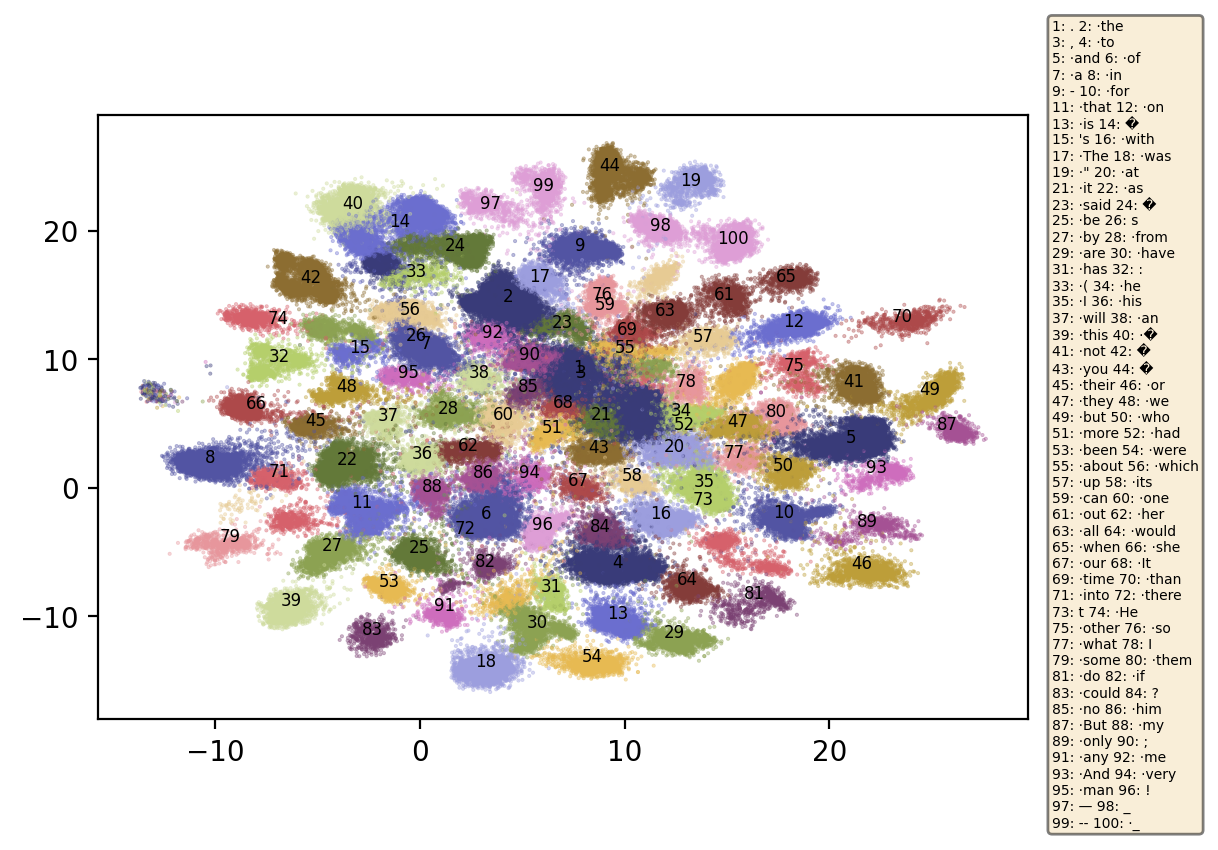

In [135]:
plot_encodings(dataset1, cluster_label_map={t:tokenizer.decode(t).replace(' ', '·')
                                            for t in dataset1.top_n_tokens_normal_train})

As observed, UMAP strongly clusters feature vectors according to their associated input tokens. In addition, we observe some evidence that feature vectors are clustered together based on proximate meaning; from the legend, we see that:
* Clusters corresponding to tokens 48 and 45 (*we* and *their*) are adjacent
* Clusters corresponding to tokens 54 and 18 (*were* and *was*) are adjacent
* Clusters corresponding to tokens 86 and 62 (*him* and *her*) are adjacent

etc.

By contrast, if we randomly project the stream embeddings, we observe no such clustering behaviour. Thus, UMAP-transformed stream embeddings appear to better preserve meaning compared to random projections.

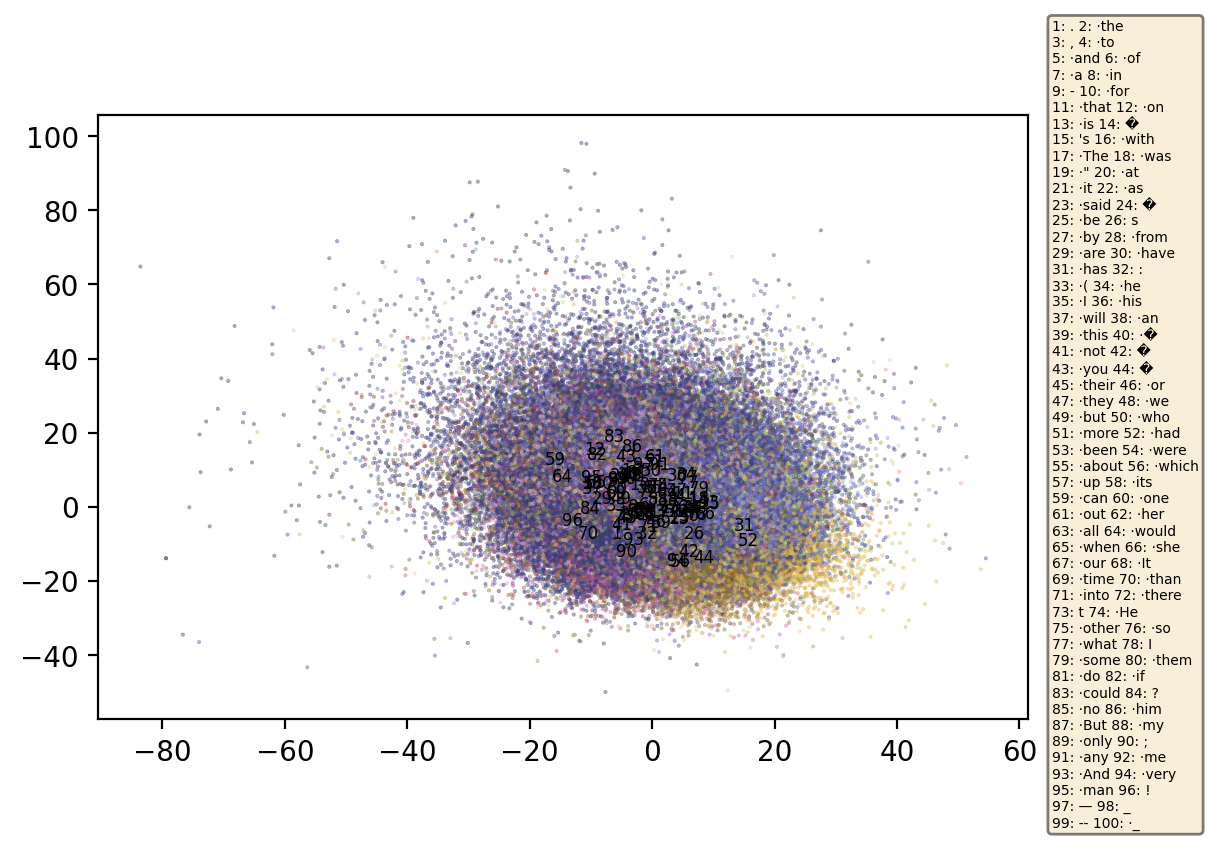

In [226]:
plot_encodings(dataset2, cluster_label_map={t:tokenizer.decode(t).replace(' ', '·') for t in dataset2.top_n_tokens_normal_train})

Exploring the effect of projecting the stream embeddings down to 4 dimensions is slightly more challenging from a visualisation perspective. We adopt the following approach:
* Partition the set of 250 tokens into training and testing subsets.
* Using the feature vectors associated with the training subset, construct a K-nearest neighbour classifier, taking the tokens as labels.
* For each token in the testing subset and for each associated feature vector, predict its token based on the feature vector.
* For each token in the testing subset, display the most frequently predicted token alongside the relative number of times it was predicted.

In [166]:
embeddings_projected_normal_train = np.vstack([np.vstack(encodings) for encodings in dataset0.embeddings_projected_normal_train])

token_ids_normal_train = np.ravel(dataset0.token_ids_normal_train)
token_ids_normal_train = token_ids_normal_train[~token_ids_normal_train.mask]

np.random.seed(6)
I = np.random.choice(len(token_ids_normal_train), size=10**6)
embeddings_projected_normal_train = embeddings_projected_normal_train[I]
token_ids_normal_train = token_ids_normal_train[I]

token_ids_normal_train_map = {k:v for k, v in Counter(token_ids_normal_train).items()}
token_ids_normal_train_map = {k:v for k, v in token_ids_normal_train_map.items() if v >= 100}

_, token_ids_test = model_selection.train_test_split(list(token_ids_normal_train_map.keys()), test_size=100)
I_train = [t not in set(token_ids_test) for t in token_ids_normal_train]
I_test = [t in set(token_ids_test) for t in token_ids_normal_train]

freqs = Counter(token_ids_normal_train[I_train])
inverse_freqs = {k:1/v for k,v in freqs.items()}
weights = np.array([inverse_freqs[c] for c in token_ids_normal_train[I_train]])
I = np.random.choice(len(weights), size=len(weights), p=weights/sum(weights))

In [167]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance',
                                             n_jobs=4).fit(embeddings_projected_normal_train[I_train][I],
                                                           token_ids_normal_train[I_train][I])
predicted_tokens = knn.predict(embeddings_projected_normal_train[I_test])

In [168]:
def display_predicted_tokens():
    np.random.seed(5)
    
    predicted_tokens_map = {t: Counter(predicted_tokens[token_ids_normal_train[I_test] == t])
                            for t in token_ids_test}
    total_counts = {k: sum(v.values()) for k, v in predicted_tokens_map.items()}
    
    predicted_tokens_map = {tokenizer.decode(k).replace(' ', '·'): [(tokenizer.decode(t).replace(' ', '·'),
                                                                     np.round(count/total_counts[k], 3))
                                                                    for t, count in v.most_common(1)]
                            for k, v, in predicted_tokens_map.items()}
    
    return predicted_tokens_map
    
predicted_tokens_map = display_predicted_tokens()

In [169]:
df_nearest_neighbours = pd.DataFrame(predicted_tokens_map).T
df_nearest_neighbours['Top Prediction'] = df_nearest_neighbours[0].apply(lambda t: t[0])
df_nearest_neighbours['Score'] = df_nearest_neighbours[0].apply(lambda t: t[1])
del df_nearest_neighbours[0]
df_nearest_neighbours.sort_values(by='Score', inplace=True, ascending=False)

pd.set_option('display.max_rows', df_nearest_neighbours.shape[0]+1)
df_nearest_neighbours.index.name = 'Actual Label'
df_nearest_neighbours[df_nearest_neighbours['Score'] > 0.5]

,Top Prediction,Score
Actual Label,,
·�,�,0.996
�,".""",0.995
",""",".""",0.992
_,._,0.991
--,],0.989
·came,·come,0.988
·_,._,0.987
·There,·there,0.984
·may,·must,0.980


From the preceding table, we observe additional evidence that when we apply UMAP, feature vectors whose associated tokens are distinct but share similar meaning are close in Euclidean space.

## Compute Path Signatures and Evaluate Anomaly Detection Performance

Finally, we evaluate the performance of training an anomaly detector, where we represent each dimensionality-reduced stream embedding using its path signature. (As a preprocessing step, we apply the cumulative sum transformation to each dimensionality-reduced stream embedding.)

Recall that we operate on chunks of text, each consisting of 512 tokens. To obtain a single anomaly score for a given work of interest $W$ (represented as multiple text chunks), we proceed as follows:
* Compute signatures for all available dimensionality-reduced stream embeddings (with one signature for each chunk).
* Use a random subset of signatures in the training corpus to train an anomaly detection model (isolation forest).
* Use the remaining subset of signatures in the training corpus to calibrate the anomaly detector. Calibration is achieved by scoring each of the signatures and computing the empirical cumulative distribution of anomaly scores $F_1$.
* Compute anomaly scores for each of the signatures corresponding to the work of interest $W$. The set of scores specifies an empirical cumulative distrbution of anomaly scores $F_2$.
* Apply a (one-sided) Kolmogorov-Smirnoff test to distributions $F_1$, $F_2$. Use the resulting p value to decide whether to treat the work of interest $W$ as anomalous.

In [170]:
class IFScorer():
    NAME = 'IsoFor'
    def __init__(self):
        self.model = ensemble.IsolationForest()

    def fit(self, normal_signatures_train):        
        self.model.fit(normal_signatures_train)
        
    def score_samples(self, signatures):
        return self.model.score_samples(signatures)

In [171]:
def compute_signature(path, truncation_level=2, cumsum_transform=True):
    path = np.vstack((np.zeros((2, path.shape[1])), path))
        
    if cumsum_transform:
        path = np.cumsum(path, axis=0)

    signature = iisignature.sig(path, truncation_level)
        
    return signature

def compute_signatures(paths, truncation_level):
    signatures = {i: np.atleast_2d([compute_signature(q, truncation_level) for q in p])
                      for i, p in enumerate(paths)}
    
    return pd.Series(signatures)

In [172]:
def compute_anomaly_scores(truncation_level=1,
                           random_seed=4,
                           scoring_classes=(IFScorer,),
                           normal_paths_train=None,
                           normal_paths_test=None,
                           anomalous_paths={'fr': None,
                                            'de': None},
                           max_train_size=100,
                           max_test_size=100):

    def _compute_signatures(paths):
        return compute_signatures(paths, truncation_level)

    np.random.seed(random_seed)

    def random_sample(paths, max_size):
        N = len(paths)
        I = np.random.choice(N, size=min([N, max_size]), replace=False)
        
        return [paths[i] for i in I if len(paths[i]) > 0]
    
    normal_paths_train = random_sample(normal_paths_train, max_train_size)
    
    normal_paths_test = random_sample(normal_paths_test, max_test_size)    
    anomalous_paths = {lang: random_sample(paths, max_test_size) for lang, paths in anomalous_paths.items()}
    
    normal_signatures_train = _compute_signatures(normal_paths_train)
    normal_signatures_train = np.array(normal_signatures_train.values.tolist())
        
    normal_signatures_test = np.array(_compute_signatures(normal_paths_test).values.tolist())
    normal_signatures_test, normal_signatures_test__score_calibration = \
        model_selection.train_test_split(normal_signatures_test, train_size=0.5)
    anomalous_signatures = {lang: _compute_signatures(paths) for lang, paths in anomalous_paths.items()}
        
    scores_normal = {}
    scores_anomalous = {}
    for score_class in scoring_classes:
        model = score_class()
        model.fit(normal_signatures_train.reshape(-1, normal_signatures_train.shape[-1]))
        
        raw_scorer = lambda samples: model.score_samples(samples.reshape(-1, normal_signatures_train.shape[-1])).reshape(-1, 10)
        calibration_scores = sorted(np.ravel(raw_scorer(normal_signatures_test__score_calibration)))
        probability_scorer = lambda samples: [scipy.stats.ks_2samp(calibration_scores, score_block, mode='exact', alternative='less').pvalue for score_block in raw_scorer(samples)]
        
        scores_normal[score_class.NAME] = probability_scorer(normal_signatures_test)
        scores_anomalous[score_class.NAME] = \
            {'_'.join((model.NAME, lang)): probability_scorer(np.array(sigs.values.tolist()))
                            for lang, sigs in anomalous_signatures.items()}
    
    return scores_normal, scores_anomalous, normal_signatures_train.shape[-1]

Apply UMAP to stream embeddings (considering 250 most frequent tokens) to obtain 4-dimensional stream embeddings, then compute signatures up to level 4:

In [173]:
def evaluate_anomaly_scores_vs_signature_length(normal_paths_train, normal_paths_test, anomalous_paths,
                                                truncation_level=range(1, 5), n_repetitions=1):
    results = defaultdict(dict)
    for l in truncation_level:
        print('Computing scores for signature level {}'.format(l))
        results['no_projection'][l] = [compute_anomaly_scores(truncation_level=l,
                                                              normal_paths_train=normal_paths_train,
                                                              normal_paths_test=normal_paths_test,
                                                              anomalous_paths=anomalous_paths,
                                                              max_train_size=10**8, max_test_size=1000)
                                                              for i in range(n_repetitions)]

    return results

dataset0.results = evaluate_anomaly_scores_vs_signature_length(dataset0.embeddings_projected_normal_train,
                                                               dataset0.embeddings_projected_normal_eval,
                                                             {'impostor': dataset0.embeddings_projected_impostor})

with open('results0.pkl', 'wb') as f:
    pickle.dump(dataset0.results, f)

Computing scores for signature level 1
Computing scores for signature level 2
Computing scores for signature level 3
Computing scores for signature level 4


Quantify performance using receiver operating characteristic area under the curve (ROCAUC):

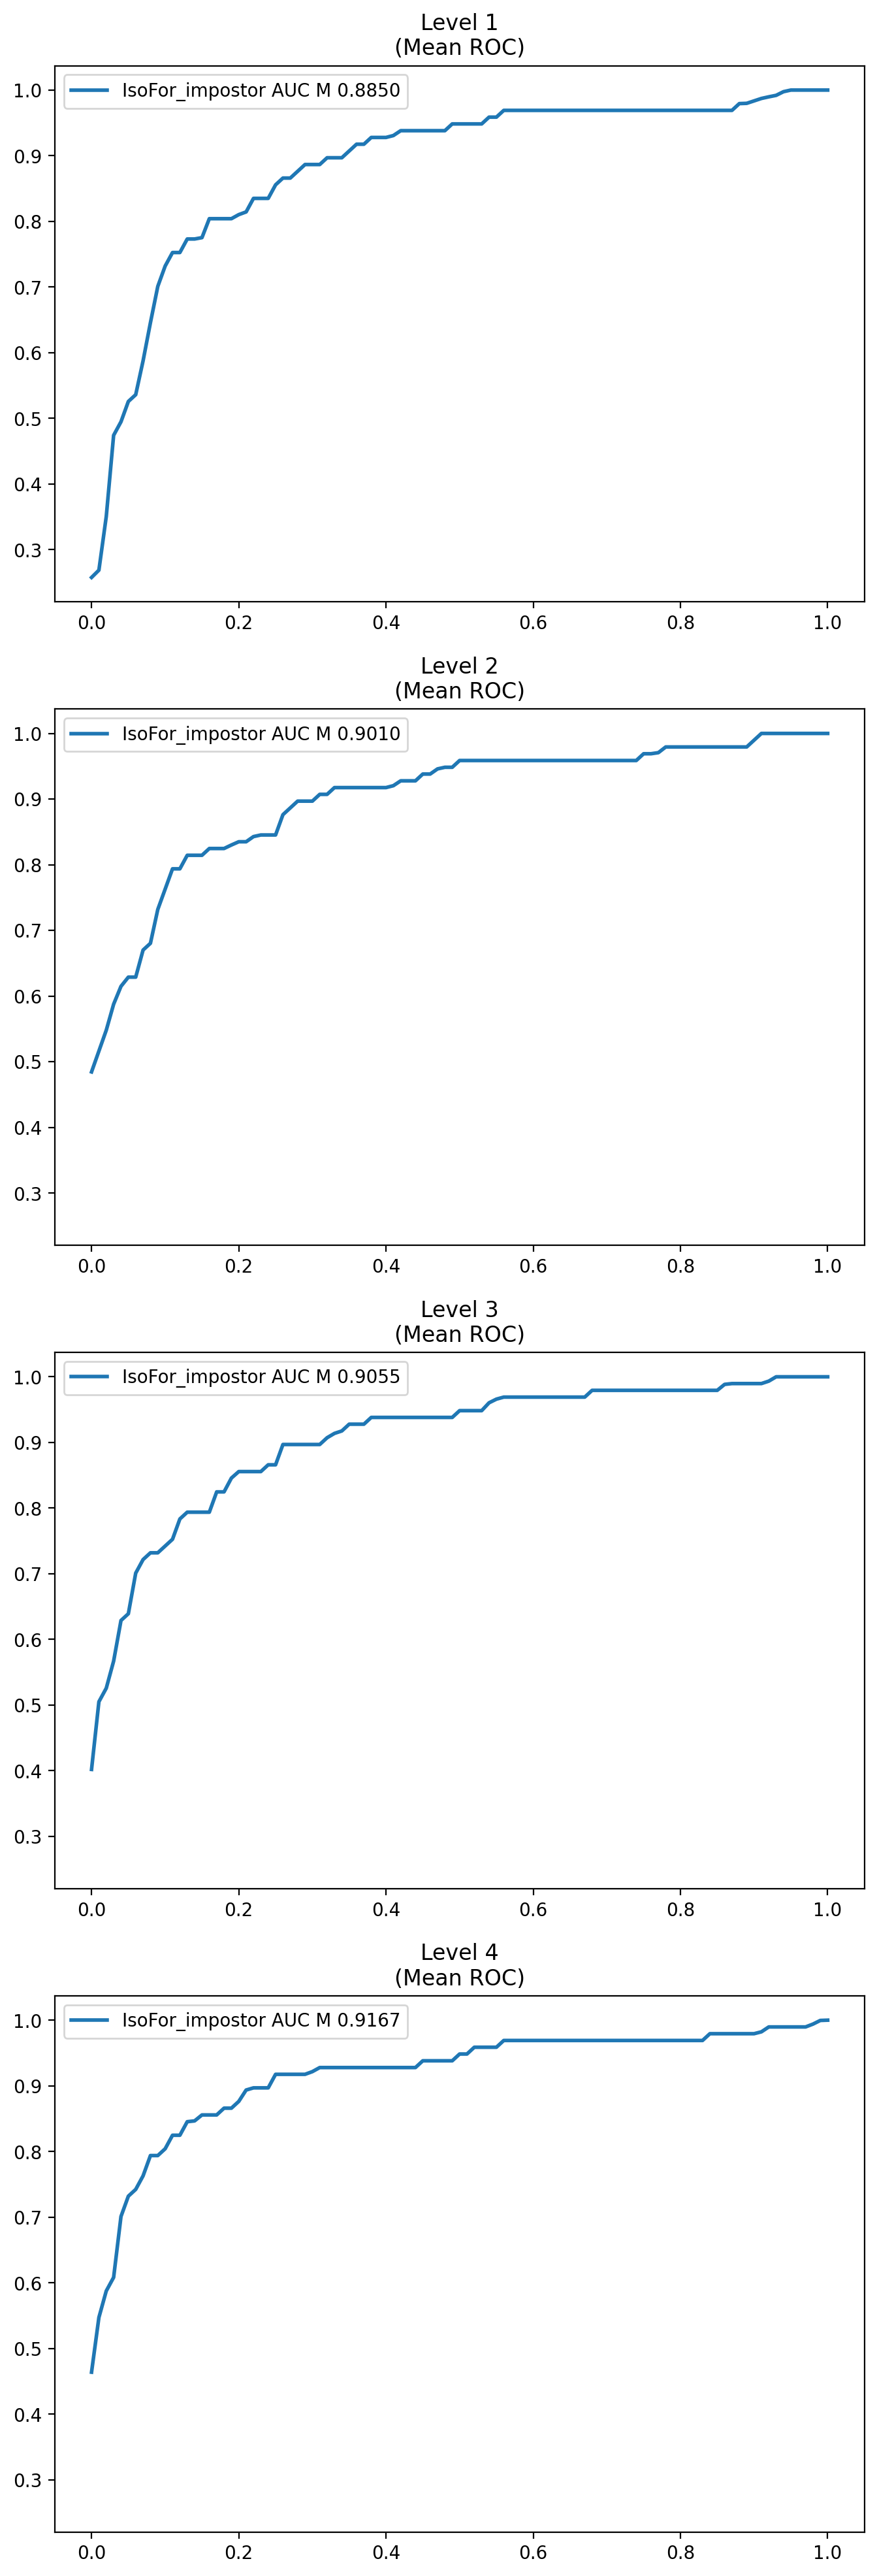

In [174]:
def plot_roc(results):
    def _plot_results(ax, normal_scores, anomalous_scores):
        
        for scoring_method in anomalous_scores.keys():
            all_labels, all_scores = list(zip(*list(anomalous_scores[scoring_method].items())))

            for label, anomalous_scores_subset in zip(all_labels, all_scores):
                tpr_all = []; roc_all = []
                base_fpr = np.linspace(0, 1, 101)

                fpr, tpr, _ = metrics.roc_curve([False] * len(normal_scores[scoring_method]) + [True] * len(anomalous_scores_subset),
                                                 -1 * np.append(normal_scores[scoring_method], anomalous_scores_subset))
                roc = metrics.auc(fpr, tpr)
                tpr = np.interp(base_fpr, fpr, tpr)

                tpr_all.append(tpr)
                roc_all.append(roc)

                ax.plot(base_fpr, np.mean(tpr_all, axis=0), lw=2,
                        label='{} AUC M {:.4f}'.format(label, np.mean(roc_all)))
        ax.legend()
    
    levels = results.keys()
        
    _, axs = plt.subplots(nrows=len(set(levels)), ncols=1, figsize=(8, 25), sharey=True)
    
    for j, level in zip(range(len(set(levels))), sorted(set(levels))):
        _plot_results(axs[j], results[level][0][0], results[level][0][1])
        axs[j].set_title('Level {}\n(Mean ROC)'.format(level))

plot_roc(dataset0.results['no_projection'])

As observed, using signatures truncated at level 4, we obtain an ROCAUC of 92%.

Next, evaluate the alternative approach of applying UMAP to stream embeddings (but considering 100 most frequent tokens) to obtain 2-dimensional stream embeddings, then computing signatures up to level 4:

In [175]:
dataset1.results = evaluate_anomaly_scores_vs_signature_length(dataset1.embeddings_projected_normal_train,
                                                               dataset1.embeddings_projected_normal_eval,
                                                             {'impostor': dataset1.embeddings_projected_impostor})

Computing scores for signature level 1
Computing scores for signature level 2
Computing scores for signature level 3
Computing scores for signature level 4


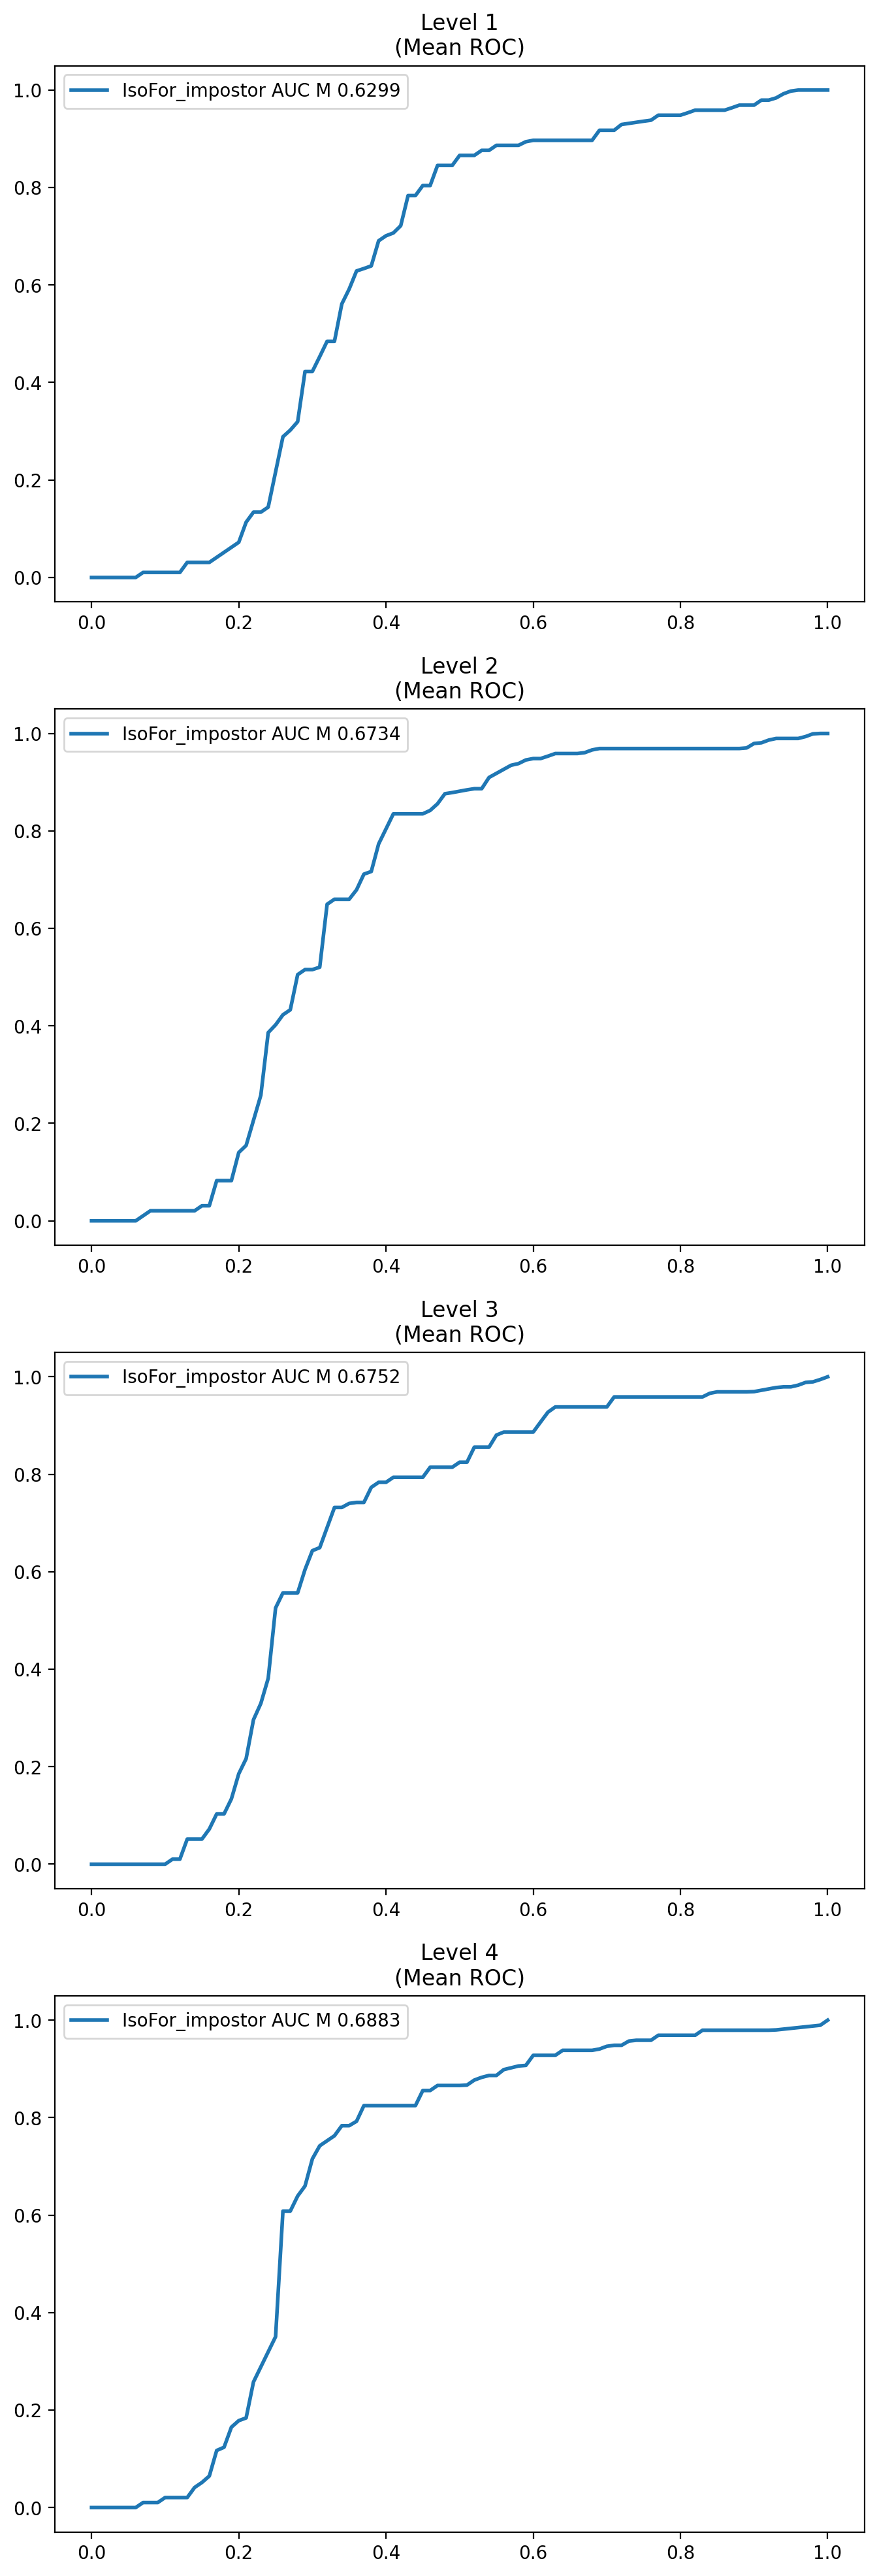

In [176]:
plot_roc(dataset1.results['no_projection'])

As observed, performance using 250 most frequent tokens is superior to that when using 100 most frequent tokens (92% vs. 69% ROCAUC).

Finally, compare results using UMAP to the random projections baseline (considering 250 most frequent tokens):

In [279]:
dataset3.results = evaluate_anomaly_scores_vs_signature_length(dataset3.embeddings_projected_normal_train,
                                                               dataset3.embeddings_projected_normal_eval,
                                                             {'impostor': dataset3.embeddings_projected_impostor})

Computing scores for signature level 1
Computing scores for signature level 2
Computing scores for signature level 3
Computing scores for signature level 4


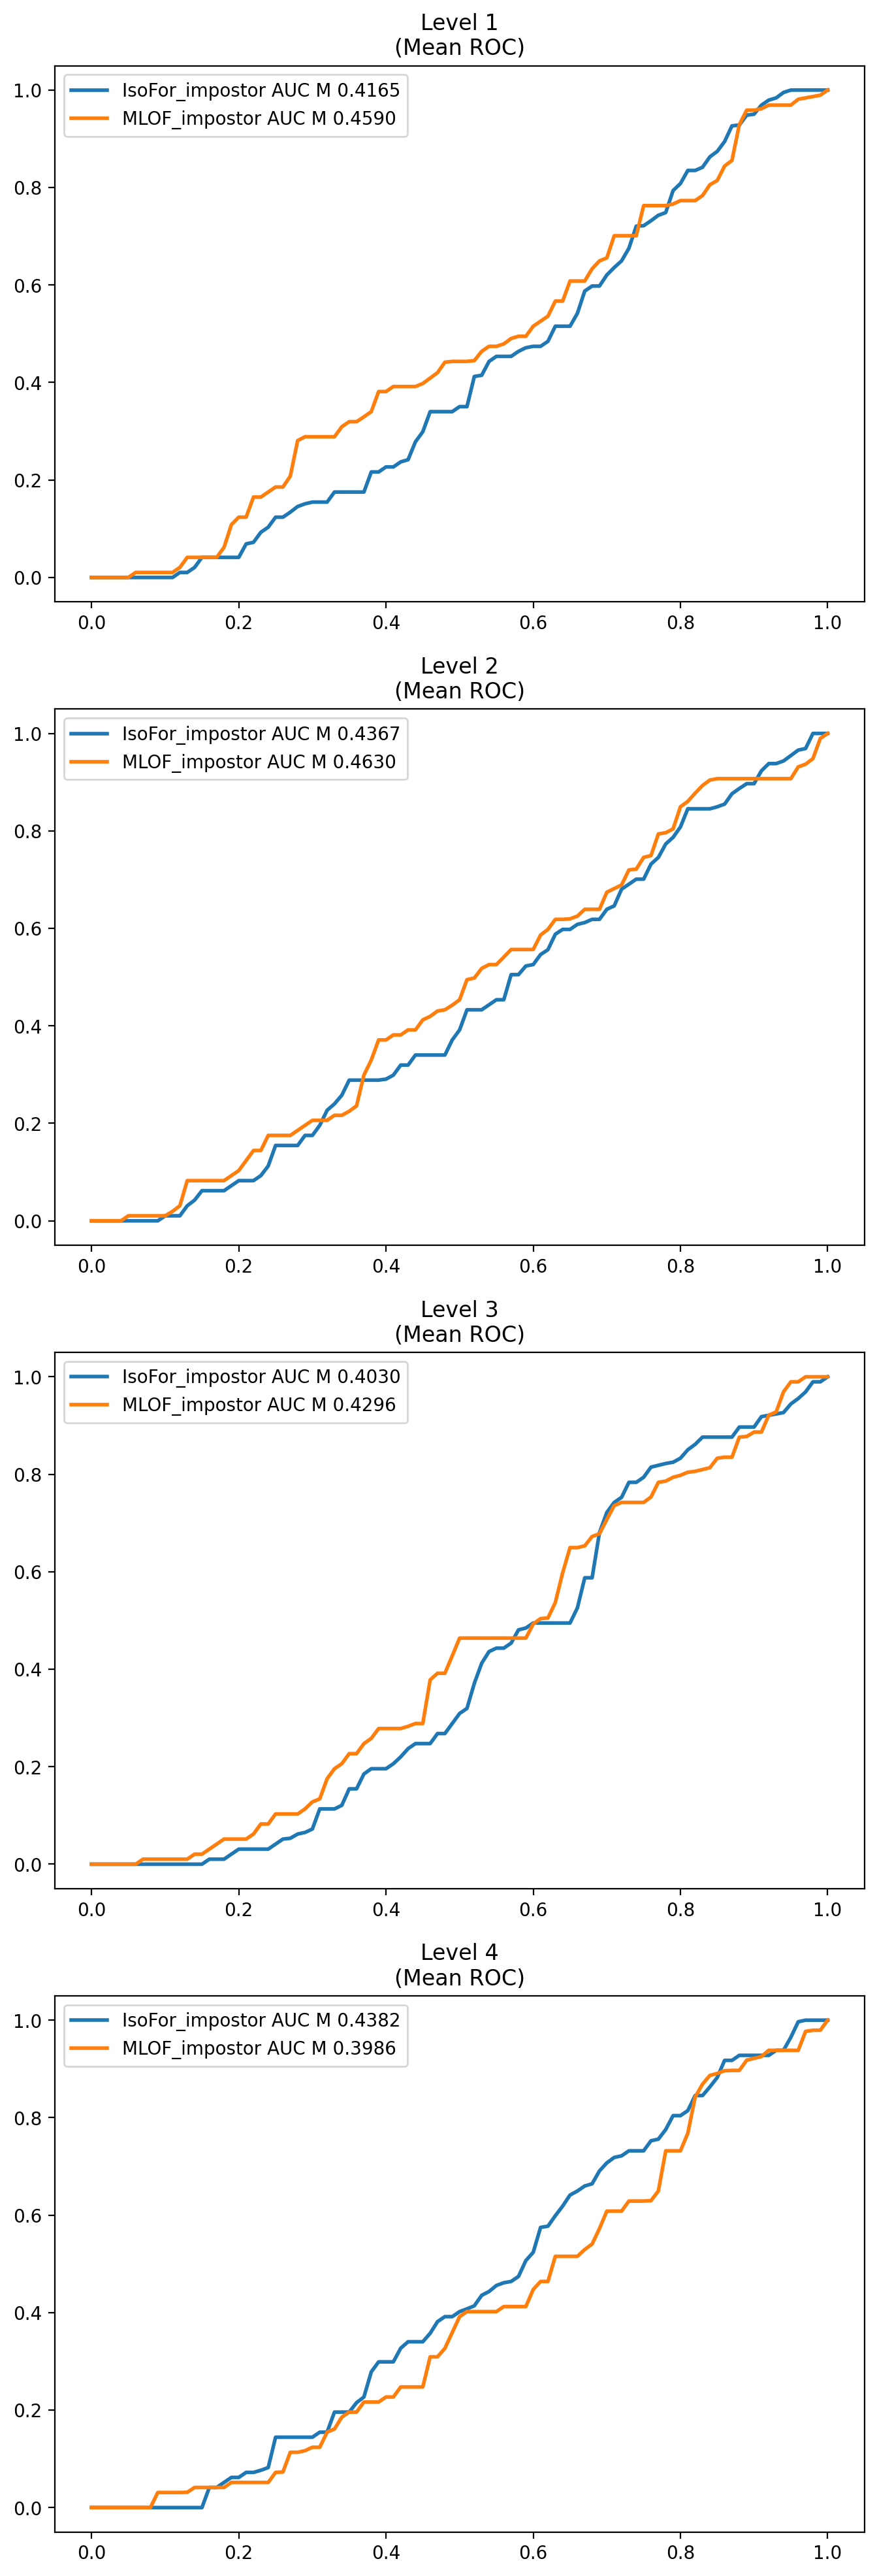

In [280]:
plot_roc(dataset3.results['no_projection'])